### Calculate family income from basic monthly CPS

September 10, 2020

Brian Dew

------

CPS variable for family income has lots of issues but is worth looking at given COVID-19 and the superdole.

In [1]:
import pandas as pd
import numpy as np
import os
import re
import struct
import gzip
import shutil
from io import BytesIO
import requests

In [2]:
os.chdir('/home/brian/Documents/CPS/data')

In [4]:
# manually list out the IDs for series of interest 
var_names = ['HRMONTH', 'HRYEAR4', 'HEFAMINC', 'PWSSWGT', 'QSTNUM', 'OCCURNUM',
             'PEMLR', 'PRTAGE', 'PESEX', 'PWFMWGT', 'HRMIS', 'HXFAMINC'] 

dd_list = {15: 'January_2015_Record_Layout.txt',
           16: 'January_2015_Record_Layout.txt',
           17: 'January_2017_Record_Layout.txt',
           18: 'January_2017_Record_Layout.txt',
           19: 'January_2017_Record_Layout.txt',
           20: '2020_Basic_CPS_Public_Use_Record_Layout_plus_IO_Code_list.txt'}

unpackers = {}
for year, dd in dd_list.items():
    # read data dictionary text file 
    data_dict = open(dd, 'r', encoding='iso-8859-1').read()
    # regular expression matching series name and data dict pattern
    p = f'\n({"|".join(var_names)})\s+(\d+)\s+.*?\t+.*?(\d\d*).*?(\d\d+)'
    # dictionary of variable name: [start, end, and length + 's']
    d = {s[0]: [int(s[2])-1, int(s[3]), f'{s[1]}s']
         for s in re.findall(p, data_dict)}
    # lists of variable starts, ends, and lengths
    start, end, width = zip(*d.values())
    # create list of which characters to skip in each row
    skip = ([f'{s - e}x' for s, e in zip(start, [0] + list(end[:-1]))])
    # create format string by joining skip and variable segments
    unpack_fmt = ''.join([j for i in zip(skip, width) for j in i])
    # struct to read each row of the file using the format string
    unpackers[year] = struct.Struct(unpack_fmt).unpack_from    

<AxesSubplot:>

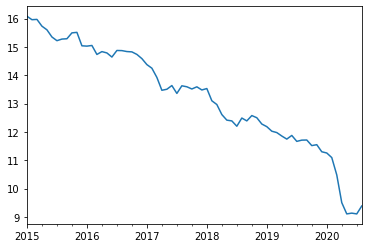

In [5]:
dates = pd.date_range(start='2015-01-01', end='2020-08-01', freq='MS').tolist()

s = {}
for date in dates:
    file = f'{date.strftime("%b%y").lower()}pub.dat'
    raw_data = open(file, 'rb').readlines()

    wgt = d['PWSSWGT']  # Person sample weight
    # unpack and store data of interest if sample weight > 0
    data = [[*map(int, unpackers[int(file[3:5])](row))] for row in raw_data
            if int(row[wgt[0]:wgt[1]]) > 0]
    
    df = pd.DataFrame(data, columns=d.keys())
    
    val = (df.groupby('HEFAMINC').PWSSWGT.sum() / 
           df.groupby('HEFAMINC').PWSSWGT.sum().sum() * 100)
    
    s[date] = val[val.index < 7].sum()
    
pd.Series(s).plot()

<AxesSubplot:>

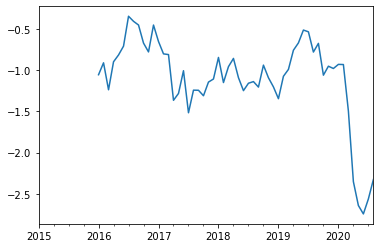

In [6]:
pd.Series(s).diff(12).plot()

In [ ]:
val = (df.query('HXFAMINC == 0').groupby('HEFAMINC').PWSSWGT.sum() / 
       df.query('HXFAMINC == 0').groupby('HEFAMINC').PWSSWGT.sum().sum() * 100)